In [ ]:
# prompt: connect eith drive

from google.colab import drive
drive.mount('/content/drive')


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-4-14 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


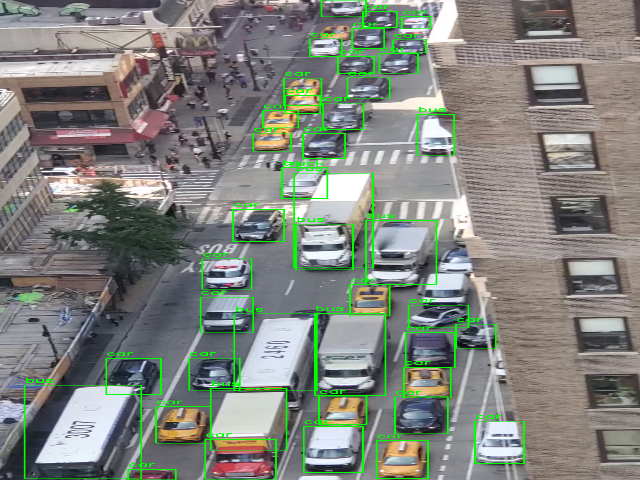

North GREEN for 60 seconds


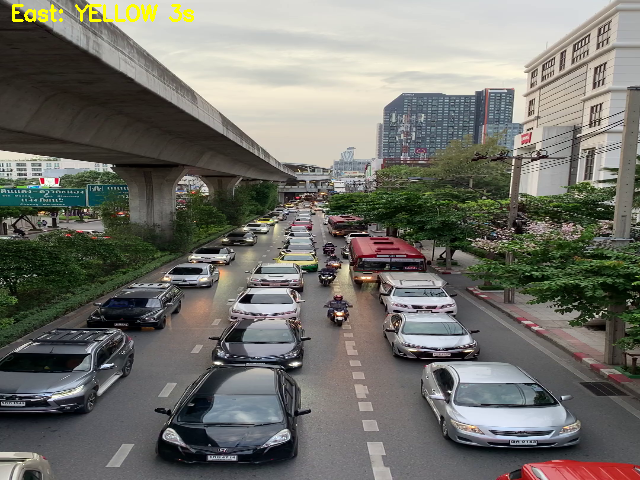

East YELLOW for 3 seconds


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


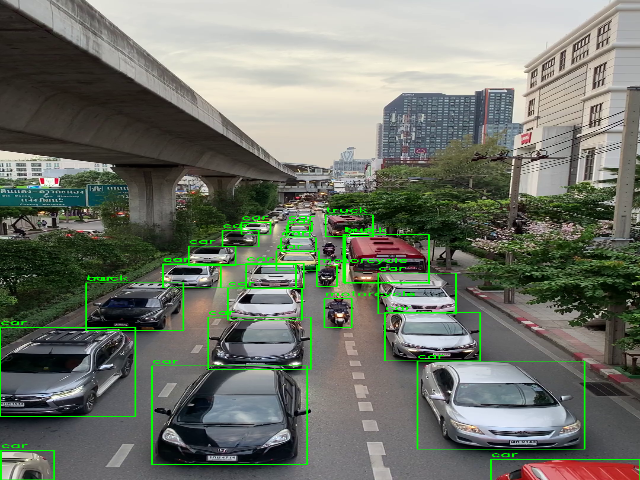

East GREEN for 60 seconds


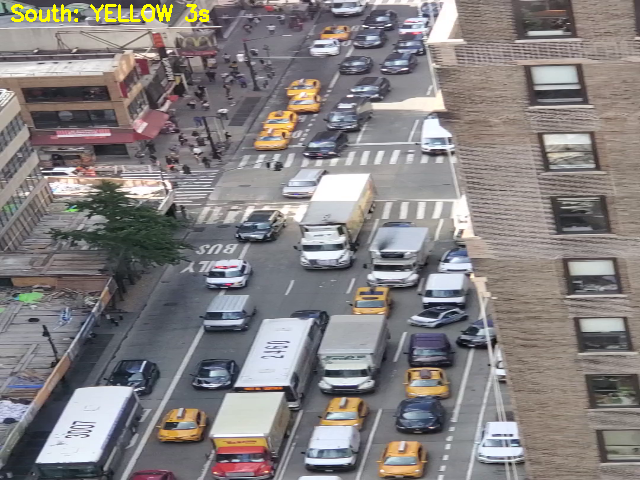

South YELLOW for 3 seconds


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


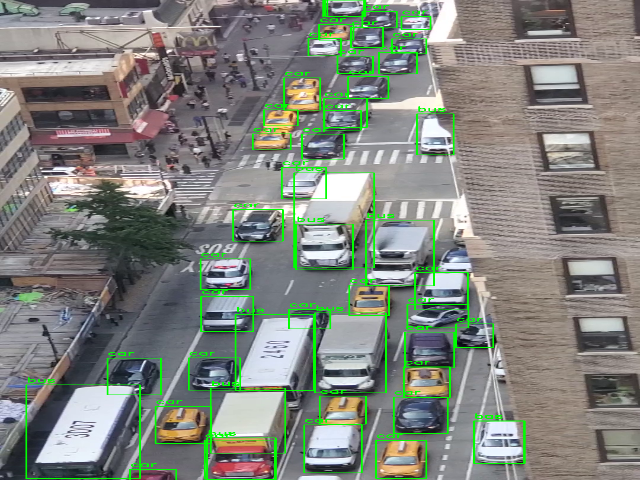

South GREEN for 60 seconds


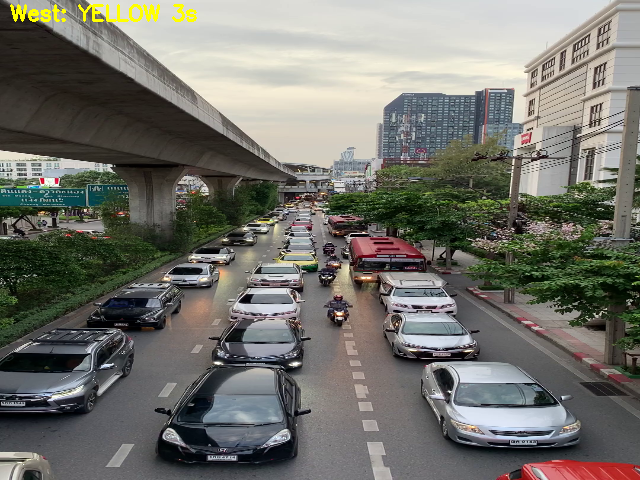

West YELLOW for 3 seconds


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


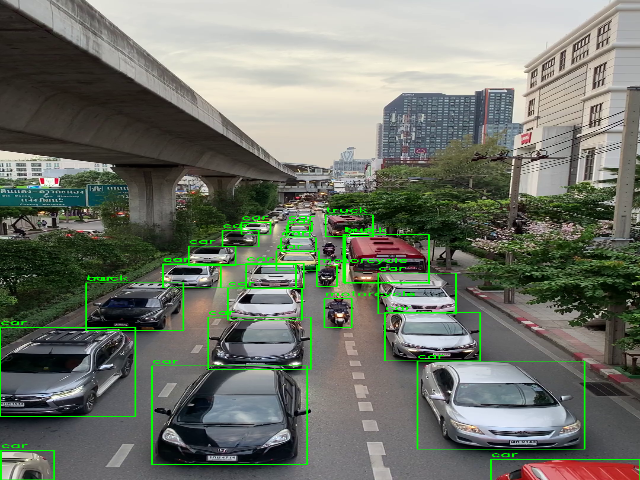

West GREEN for 60 seconds


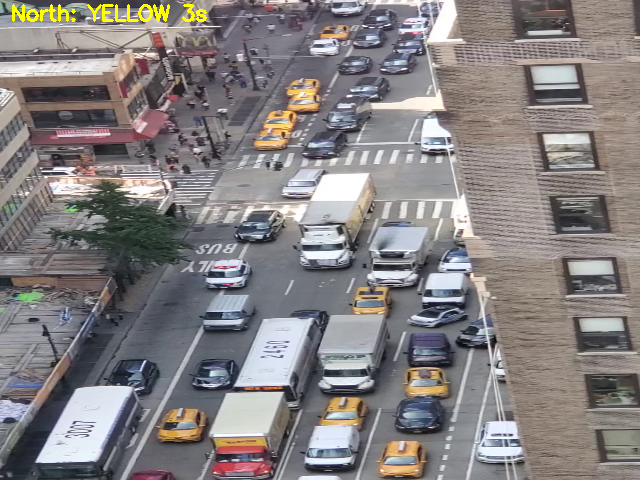

North YELLOW for 3 seconds


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


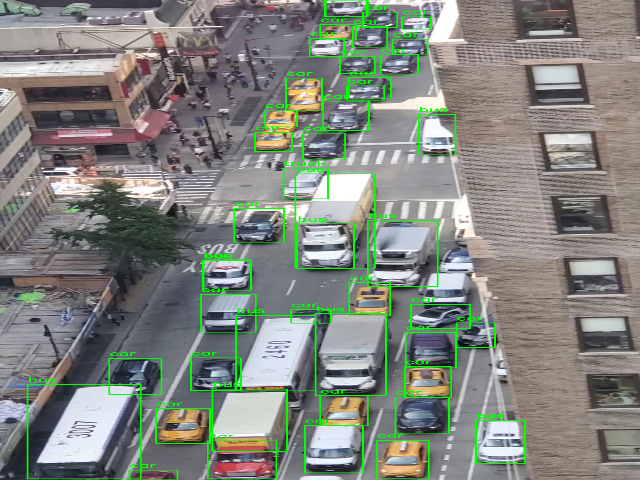

North GREEN for 60 seconds


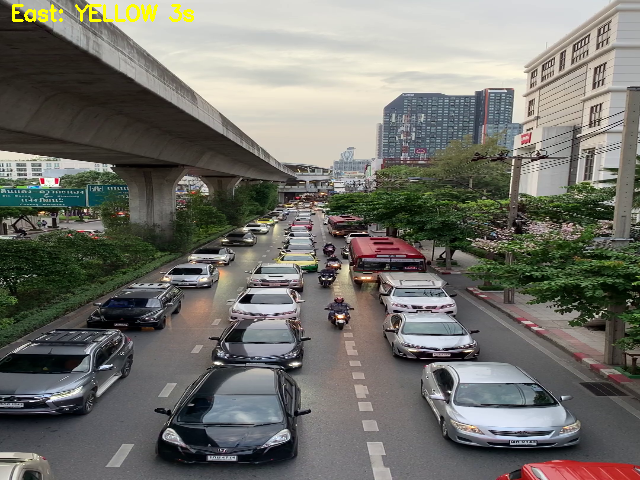

East YELLOW for 3 seconds


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


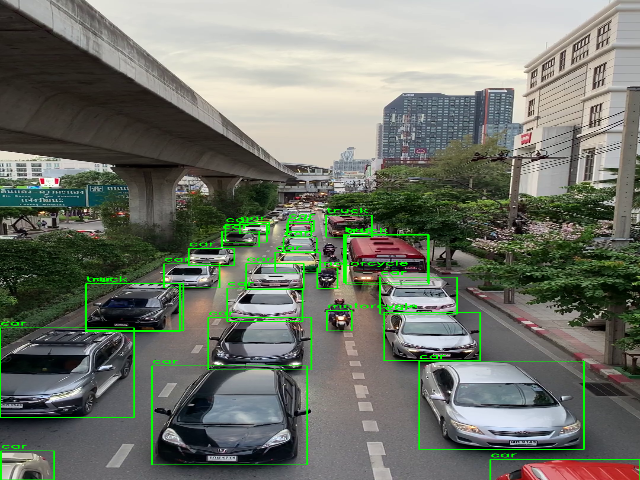

East GREEN for 60 seconds


KeyboardInterrupt: 

In [3]:
!pip install Pillow
from PIL import Image
import cv2
import torch
import time
from google.colab.patches import cv2_imshow # Import cv2_imshow
from IPython.display import display, clear_output

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

vehicle_classes = [2, 3, 5, 7]  # car, motorcycle, bus, truck

# Video sources for 4 cameras
video_sources = ['/content/sample_data/3438446-hd_1080_1920_30fps.mp4',
                 '/content/sample_data/5927708-hd_1080_1920_30fps.mp4',
                 '/content/sample_data/3438446-hd_1080_1920_30fps.mp4',
                 '/content/sample_data/5927708-hd_1080_1920_30fps.mp4']

signal_names = ['North', 'East', 'South', 'West']

# Vehicle type weights
vehicle_weights = {
    'car': 1,
    'motorcycle': 0.5,
    'bus': 2,
    'truck': 2.5
}


def calculate_weighted_count(vehicles):
    count = 0
    for _, row in vehicles.iterrows():
        label = row['name']
        count += vehicle_weights.get(label, 1)
    return count


def calculate_green_signal(weighted_count):
    base_time = 5  # Minimum green time
    time_per_weight = 2
    return min(60, base_time + int(weighted_count * time_per_weight))


# Main logic for adaptive traffic signals
caps = [cv2.VideoCapture(source) for source in video_sources]  # Initialize capture objects

while True:
    for i in range(4):
        ret, frame = caps[i].read()  # Read from the current camera
        if not ret:
            print(f"Error reading frame from camera {i}. Exiting...")
            break

        # Object Detection and Vehicle Counting
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = model(img)
        df = results.pandas().xywh[0]
        vehicles = df[df['class'].isin(vehicle_classes)]

        # Calculate green duration based on detected vehicles
        vehicle_count = calculate_weighted_count(vehicles)
        green_duration = calculate_green_signal(vehicle_count)

        # Draw bounding boxes and labels on detected vehicles
        for index, row in vehicles.iterrows():
            x1 = int(row['xcenter'] - row['width'] / 2)
            y1 = int(row['ycenter'] - row['height'] / 2)
            x2 = int(row['xcenter'] + row['width'] / 2)
            y2 = int(row['ycenter'] + row['height'] / 2)
            label = row['name']

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        resized_frame = cv2.resize(frame, (640, 480))

        # Display the frame using cv2_imshow
        cv2_imshow(resized_frame)

        print(f"{signal_names[i]} GREEN for {green_duration} seconds")
        time.sleep(green_duration)

        # Simulate yellow signal for next signal
        next_index = (i + 1) % 4
        ret, next_frame = caps[next_index].read()  # Read from the next camera
        if ret:
            next_frame = cv2.resize(next_frame, (640, 480))
            cv2.putText(next_frame, f'{signal_names[next_index]}: YELLOW 3s', (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
            cv2_imshow(next_frame) # Display the yellow signal frame
            print(f"{signal_names[next_index]} YELLOW for 3 seconds")
            time.sleep(3)

    # The break statement has been removed to make the loop infinite
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release all camera capture objects and close OpenCV windows
for cap in caps:
    cap.release()
cv2.destroyAllWindows()